In [1]:
# TODO: get rid of hacks like this by adding a setup.py scripts to base and installing the package
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from pykeen.triples import TriplesFactory
from dataset import load_lnctard, create_splits, df2nx
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

In [5]:
DATA_DIR = "../data"

In [6]:
df = load_lnctard('../data/lnctard2.0.txt', cols="Regulator	SearchregulatoryMechanism	Target".split())

In [7]:
df.head()

,Regulator,SearchregulatoryMechanism,Target
0,LINC00313,ceRNA or sponge,miR-4429
1,FAM83H-AS1,epigenetic regulation,CDKN1A
2,NEAT1,ceRNA or sponge,TGFB1
3,NEAT1,ceRNA or sponge,ZEB1
4,ZFPM2-AS1,interact with protein,MIF


In [8]:
G = df2nx(
  df,
  head="Regulator", tail="Target", relation="SearchregulatoryMechanism",
  cc_mode="largest",
)

In [9]:
dataset = np.array([(h,r,t) for h,t,r in G.edges(data="SearchregulatoryMechanism")])

In [10]:
f"dataset contains {len(dataset)} triples"

'dataset contains 7144 triples'

In [11]:
splitnames = "train_m train_s val test".split()

In [18]:
splits = dict(zip(splitnames, create_splits(dataset)))
for splitname, subset in splits.items():
  id2ent, id2rel = subset.entity_labeling.id_to_label, subset.relation_labeling.id_to_label
  pd.DataFrame(
    [(id2ent[h.item()], id2rel[r.item()], id2ent[t.item()]) for h,r,t in subset.mapped_triples],
    columns=["head", "relation", "tail"],
  ).to_csv(os.path.join(DATA_DIR, f"{splitname}.tsv"), sep="\t", index=None)
  print(splitname, "contains", len(subset.mapped_triples), "triples (%.02f%%)" % (len(subset.mapped_triples)/len(dataset)*100))

14:36:12   done splitting triples to groups of sizes [2880, 714, 715]


14:36:12   done splitting triples to groups of sizes [1737, 1143]
train_m contains 4572 triples (64.00%)
train_s contains 1143 triples (16.00%)
val contains 714 triples (9.99%)
test contains 715 triples (10.01%)


In [22]:
f'total train set size: {len(splits["train_m"].mapped_triples) + len(splits["train_s"].mapped_triples)}'

'total train set size: 5715'

111
46
56
46


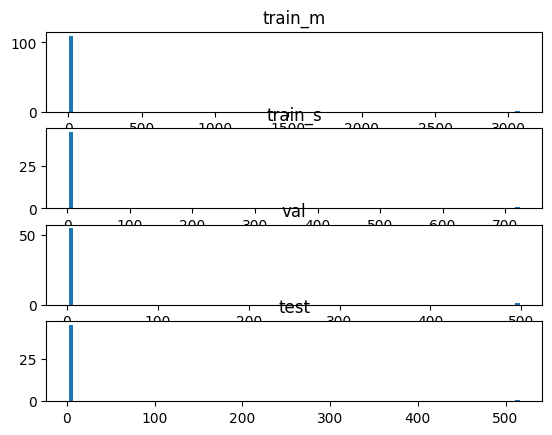

In [174]:
for idx, splitname in enumerate(splitnames):
  df = pd.read_csv(os.path.join(DATA_DIR, f"{splitname}.tsv"), sep="\t")
  split_G, conn_comps = df2nx(df,cc_mode="all")
  plt.subplot(len(splitnames),1,idx+1)
  plt.title(splitname)
  plt.hist([len(c) for c in conn_comps],bins=100)
  print(len(conn_comps))